In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import numpy as np

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tsextract.feature_extraction.extract import build_features

import matplotlib as plt

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
df_init = pd.read_csv('4362249.csv')
df_init.head()

,DateTime,Vehicles
0,01 00:00:00,559
1,01 01:00:00,585
2,01 02:00:00,425
3,01 03:00:00,284
4,01 04:00:00,389


In [3]:
features_request = {
    "window":[24]
}

TRAIN_RATIO = 0.8

X = build_features(df_init["Vehicles"], features_request, target_lag = 1, include_tzero=False)

window_size = features_request['window'][0]

y = df_init[['Vehicles']][window_size:-1]

X_train = X[:int(X.shape[0] * TRAIN_RATIO)]
y_train = y[:int(y.shape[0] * TRAIN_RATIO)]

X_test = X[int(X.shape[0] * TRAIN_RATIO):]
y_test = y[int(y.shape[0] * TRAIN_RATIO):]

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = pd.DataFrame(y_scaler.fit_transform(y_train), index = y_train.index)

X_test_scaled = X_scaler.fit_transform(X_test)
y_test_scaled = pd.DataFrame(y_scaler.fit_transform(y_test), index = y_test.index)

In [4]:
parameters = {'kernel' : ['rbf'],
              'C' : np.arange(1e-4, 1e-0, 4e-2),
              'epsilon' : np.arange(1e-4, 1e-2, 4e-4)}
svr = GridSearchCV(SVR(), parameters)
svr.fit(X_train_scaled, y_train_scaled)
print(svr.best_params_)

{'C': 0.6001, 'epsilon': 0.0097, 'kernel': 'rbf'}


In [5]:
y_test_predict = pd.DataFrame(svr.predict(X_test_scaled), index = y_test.index, columns = ['Vehicles']).apply(y_scaler.inverse_transform)

0.8436326164178631
113.33837535067302
90.43500893617048


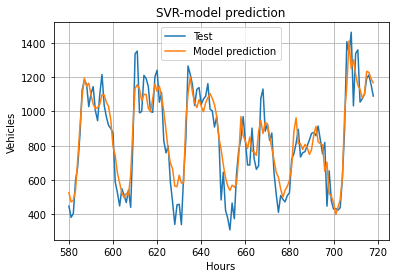

In [6]:
ax = y_test.plot()
y_test_predict.plot(ax = ax)
print(r2_score(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict, squared=False))
print(mean_absolute_error(y_test, y_test_predict))
ax.legend(['Test', 'Model prediction'])
ax.set_xlabel('Hours')
ax.set_ylabel('Vehicles')
ax.set_title('SVR-model prediction')
ax.grid('on')

In [7]:
def rolling_prediction(model, df_init, timesteps):
    df = df_init.copy()
    df_windowed = df.copy()
    for i in range(0, timesteps):
        df_windowed = df[-2*window_size:]
        new = pd.DataFrame({"DateTime" : df_windowed.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                           "Vehicles" : df['Vehicles'].iloc[-1]}, index = [df.shape[0]])
        df_windowed = df_windowed.append(new)
        features = build_features(df_windowed["Vehicles"], features_request, target_lag = 1, include_tzero=False)
        features_scaled = pd.DataFrame(X_scaler.fit_transform(features), index=features.index, columns=features.columns)
        y_predict = pd.DataFrame({"DateTime" : df.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                           "Vehicles" : y_scaler.inverse_transform(model.predict(features_scaled.iloc[[-1]]))}, index = [df.shape[0]])
        df = df.append(y_predict)
    return df

In [8]:
timesteps = 5
df = rolling_prediction(svr, df_init, timesteps)

<AxesSubplot:>

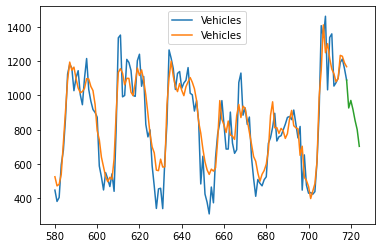

In [9]:
ax = y_test.plot()
y_test_predict.plot(ax = ax)
df['Vehicles'][-timesteps - 2:].plot(ax = ax)